In [ ]:
! pip install datasets
! pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# Configuration parameters
NUM_ROWS_SAMPLED = 10000  # Number of rows to sample
CUSTOM_K = None  # Set to a number to override the elbow method
MAX_FEATURES = 100  # Max features for TF-IDF
RANDOM_STATE = 42  # For reproducibility
SAVE_FIGURES = True  # Whether to save figures

In [ ]:
# Load the dataset (with error handling)
try:
    data = pd.read_parquet('sample_subset_indo_saja.parquet')
    print("Successfully loaded the dataset from parquet file.")
except:
    print("Could not find the parquet file. Loading from original source...")
    # Original dataset loading code
    from datasets import load_dataset
    from sklearn.model_selection import train_test_split

    ds = load_dataset("indonlp/cendol_collection_v2")

    # Define the specific subsets to include
    subset_indo_saja = ds["train"].filter(lambda example: example["subset_name"] in {
        'indo_puisi', 'wikihow', 'wikipedia_id', 'safety_prompt', 'identity_prompt', 'dolly'
    })

    # Check if we have enough data for the requested sample size
    if len(subset_indo_saja) <= NUM_ROWS_SAMPLED:
        # If we have fewer rows than requested, use all available data
        sample_subset_indo_saja = subset_indo_saja
        print(f"Using all available data: {len(sample_subset_indo_saja)} rows")
    else:
        # Stratified sampling based on template_name to maintain distribution
        template_names = subset_indo_saja['template_name']

        try:
            # Try stratified sampling first
            _, sample_indices = train_test_split(
                range(len(subset_indo_saja)),
                test_size=NUM_ROWS_SAMPLED/len(subset_indo_saja),
                stratify=template_names,
                random_state=RANDOM_STATE
            )
        except ValueError:
            # Fallback to random sampling if stratify fails (e.g., with too many classes)
            print("Stratified sampling failed, using random sampling instead")
            np.random.seed(RANDOM_STATE)
            sample_indices = np.random.choice(
                range(len(subset_indo_saja)),
                size=NUM_ROWS_SAMPLED,
                replace=False
            )

        sample_subset_indo_saja = subset_indo_saja.select(sample_indices)
        print(f"Sampled {len(sample_subset_indo_saja)} rows out of {len(subset_indo_saja)}")

    # Convert to pandas DataFrame
    data = pd.DataFrame(sample_subset_indo_saja)
    data.to_parquet('sample_subset_indo_saja.parquet')
    print("Dataset loaded from source and saved to parquet file.")

Successfully loaded the dataset from parquet file.


In [ ]:
# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print("Dataset columns:", data.columns.tolist())
print("\nSample of the data:")
print(data.head(2))

# Let's explore the distribution of subset_name and template_name
print("\nDistribution of subset_name:")
print(data['subset_name'].value_counts())

print("\nDistribution of template_name:")
print(data['template_name'].value_counts().head(10))

Dataset shape: (10000, 7)
Dataset columns: ['dataset_name', 'subset_name', 'prompt_id', 'template_name', 'dataset_key', 'input', 'output']

Sample of the data:
  dataset_name   subset_name                             prompt_id  \
0  nusa_t2t_v2  wikipedia_id  64a2ab72-18e4-4e66-bb04-71f861e3ca06   
1  nusa_t2t_v2  wikipedia_id  200186d6-de5f-499f-bfc3-a49bfa6cccfd   

            template_name dataset_key  \
0     wikipedia_section_2       train   
1  wikipedia_subsection_0       train   

                                               input  \
0                        Stasiun Jūkujō itu apa sih?   
1  Tolong jelaskan mengenai Rumus Naegle dari Keh...   

                                              output  
0  adalah sebuah stasiun kereta api di kota Mizuh...  
1  Jika tahun tetap adalah  dari haid terakhir.\n...  

Distribution of subset_name:
subset_name
wikipedia_id                                 4758
wikipedia_ms                                 1624
wikipedia_min                

In [ ]:
# Prepare the data for clustering
# 1. Text feature extraction using TF-IDF
text_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,  # Limit features to avoid dimensionality issues
    stop_words='english',  # Remove English stop words (might need custom Indonesian stop words)
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Check if 'text' column exists and find the appropriate text column
if 'text' in data.columns:
    text_column = 'text'
elif 'prompt' in data.columns:
    text_column = 'prompt'
else:
    # Find potential text columns
    potential_text_columns = []
    for col in data.columns:
        if data[col].dtype == 'object':
            try:
                if isinstance(data[col].iloc[0], str) and len(data[col].iloc[0].split()) > 5:
                    potential_text_columns.append(col)
            except:
                continue

    if potential_text_columns:
        text_column = potential_text_columns[0]
    else:
        raise ValueError("Could not find a suitable text column for analysis")

print(f"\nUsing '{text_column}' column for text vectorization")

# Fill NaN values in text column if any
data[text_column] = data[text_column].fillna("")

# Apply TF-IDF vectorization
try:
    text_features = text_vectorizer.fit_transform(data[text_column])
    print(f"Text features shape after TF-IDF: {text_features.shape}")
except Exception as e:
    print(f"Error during text vectorization: {e}")
    # Fallback to just using a small amount of text data if there's an issue
    text_features = text_vectorizer.fit_transform(data[text_column].astype(str).str[:1000])
    print(f"Using truncated text. Text features shape after TF-IDF: {text_features.shape}")


Using 'output' column for text vectorization
Text features shape after TF-IDF: (10000, 100)


In [ ]:
# 2. Feature engineering - add categorical features as one-hot encoding
categorical_features = pd.get_dummies(data[['subset_name', 'template_name']], drop_first=True)
print(f"Categorical features shape: {categorical_features.shape}")

# Convert sparse matrix to dense for concatenation
text_features_dense = text_features.toarray()

# Combine features (text features and categorical features)
combined_features = np.hstack((text_features_dense, categorical_features.values))
print(f"Combined features shape: {combined_features.shape}")

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
print(f"Reduced features shape: {reduced_features.shape}")

Categorical features shape: (10000, 204)
Combined features shape: (10000, 304)
Reduced features shape: (10000, 2)


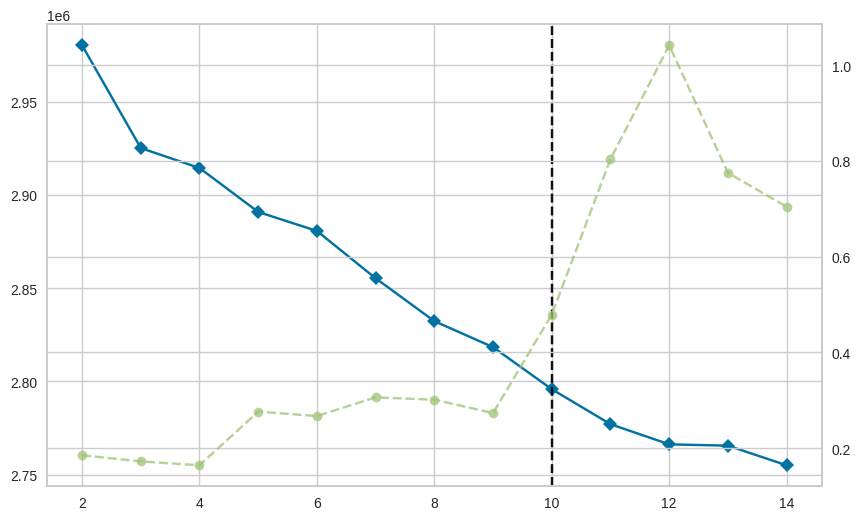

Optimal number of clusters: 10


In [ ]:
# Finding the optimal number of clusters using the Elbow Method
if CUSTOM_K is None:
    try:
        plt.figure(figsize=(10, 6))
        elbow = KElbowVisualizer(KMeans(random_state=RANDOM_STATE), k=(2, 15))
        elbow.fit(scaled_features)
        if SAVE_FIGURES:
            plt.savefig('elbow_method.png')
        plt.show()
        optimal_k = elbow.elbow_value_ if elbow.elbow_value_ is not None else 5
    except:
        # Fallback if visualization fails
        optimal_k = 5
        print("Could not visualize elbow method, using default k=5")
else:
    optimal_k = CUSTOM_K
    print(f"Using custom k value: {optimal_k}")

print(f"Optimal number of clusters: {optimal_k}")

In [ ]:
# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the original dataframe
data['cluster'] = cluster_labels

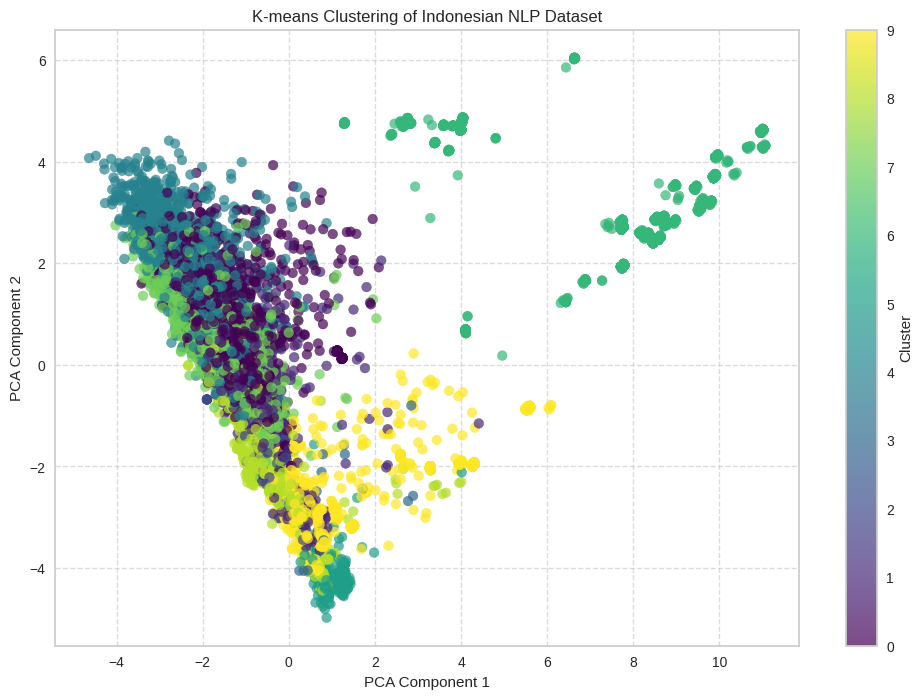

In [ ]:
# Visualize the clusters using PCA-reduced features
try:
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
                         c=cluster_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title('K-means Clustering of Indonesian NLP Dataset')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('kmeans_clusters_visualization.png')
    plt.show()
except Exception as e:
    print(f"Error during visualization: {e}")
    print("Could not create visualization. Continuing with analysis.")

In [ ]:
# Analyze the clusters
print("\nCluster distribution:")
print(data['cluster'].value_counts())

# Let's see what characterizes each cluster
for cluster_id in range(optimal_k):
    cluster_data = data[data['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")

    # Top subset_names in this cluster
    print("Top subset_names:")
    print(cluster_data['subset_name'].value_counts().head(3))

    # Top template_names in this cluster
    print("Top template_names:")
    print(cluster_data['template_name'].value_counts().head(3))

    # Sample texts from this cluster
    print("Sample text:")
    try:
        sample_text = cluster_data[text_column].iloc[0]
        print(sample_text[:200] + "..." if len(sample_text) > 200 else sample_text)
    except:
        print("No text sample available")
    print("-" * 50)


Cluster distribution:
cluster
9    2128
0    2064
4    1822
7    1298
6    1030
1     643
8     556
5     279
3     109
2      71
Name: count, dtype: int64

Cluster 0 (2064 samples):
Top subset_names:
subset_name
wikipedia_id    2023
wikipedia_ms      20
dolly             13
Name: count, dtype: int64
Top template_names:
template_name
wikipedia_section_2    249
wikipedia_section_0    245
wikipedia_section_4    239
Name: count, dtype: int64
Sample text:
Jika tahun tetap adalah  dari haid terakhir.

Haid terakhir tanggal 16-1-2016, maka Hari taksiran persalinan:

DD = 16 + 7 = 23

MM = 1 + 9 = 10

Jadi, HPL = 23 Oktober 2016

Jika tahun bertambah satu...
--------------------------------------------------

Cluster 1 (643 samples):
Top subset_names:
subset_name
wikipedia_id     339
wikipedia_ms     192
wikipedia_bjn     38
Name: count, dtype: int64
Top template_names:
template_name
wikipedia_section_daerah_0    68
wikipedia_section_daerah_4    50
wikipedia_section_daerah_2    43
Name: coun

In [ ]:
# Additional Analysis
# Create a heatmap of feature importance per cluster
# This is the line that was missing and caused the error
cluster_centers = kmeans.cluster_centers_

# Get the most important features (words) for each cluster
try:
    if hasattr(text_vectorizer, 'get_feature_names_out'):
        feature_names = text_vectorizer.get_feature_names_out()
    else:
        feature_names = text_vectorizer.get_feature_names()

    # Extract text features importance from cluster centers
    text_feature_importance = cluster_centers[:, :len(feature_names)]

    # Get top 5 important features for each cluster
    top_features_per_cluster = {}
    for i in range(optimal_k):
        top_indices = text_feature_importance[i].argsort()[-5:][::-1]
        top_features_per_cluster[i] = [feature_names[idx] for idx in top_indices]

    print("\nTop features (words/phrases) per cluster:")
    for cluster, features in top_features_per_cluster.items():
        print(f"Cluster {cluster}: {', '.join(features)}")
except Exception as e:
    print(f"Error during feature importance analysis: {e}")
    print("Could not extract top features per cluster.")


Top features (words/phrases) per cluster:
Cluster 0: adalah, pada, tahun, film, seorang
Cluster 1: kota, daerah, wilayah, sekolah, timur
Cluster 2: bisa, ke, itu, yang, tidak
Cluster 3: bisa, tidak, anak, dua, daerah
Cluster 4: yang, untuk, dengan, bahwa, karena
Cluster 5: ing, lan, bisa, tanggal, para
Cluster 6: ordo, famili, bagian dari, kingdom, spesies
Cluster 7: daripada, beliau, kepada, telah, dan
Cluster 8: kecamatan, kabupaten, desa, indonesia, timur
Cluster 9: asteroid, tidak, ko, nan, salah


In [ ]:
# Save the clustered data as parquet
try:
    data.to_parquet('kmeans_clustered_data.parquet', index=False)
    print("\nClustered data saved to 'kmeans_clustered_data.parquet'")
except Exception as e:
    print(f"Error saving Parquet file: {e}")


Clustered data saved to 'kmeans_clustered_data.parquet'

Clustering Summary:
- Dataset: Indonesian NLP dataset with 10000 samples
- Features used: TF-IDF vectorization of 'output' + categorical features
- Number of clusters: 10
- Largest cluster: Cluster 9 with 2128 samples
- Smallest cluster: Cluster 2 with 71 samples

Clustering completed successfully!


In [ ]:
# Generate cluster-specific information
print("\nDetailed Cluster Analysis:")
for cluster_id in range(optimal_k):
    cluster_data = data[data['cluster'] == cluster_id]

    print(f"\n== CLUSTER {cluster_id} SUMMARY ==")
    print(f"Number of samples: {len(cluster_data)}")

    # Distribution by subset
    print("\nSubset distribution:")
    subset_dist = cluster_data['subset_name'].value_counts()
    for subset, count in subset_dist.items():
        percentage = (count / len(cluster_data)) * 100
        print(f"- {subset}: {count} samples ({percentage:.1f}%)")

    # Try to characterize the cluster
    if 'indo_puisi' in subset_dist and subset_dist['indo_puisi'] / len(cluster_data) > 0.5:
        print("This appears to be primarily a poetry cluster.")
    elif 'wikipedia_id' in subset_dist and subset_dist['wikipedia_id'] / len(cluster_data) > 0.5:
        print("This appears to be primarily a Wikipedia content cluster.")
    elif 'wikihow' in subset_dist and subset_dist['wikihow'] / len(cluster_data) > 0.5:
        print("This appears to be primarily a how-to/instructional content cluster.")

    # Print separator
    print("-" * 50)


Detailed Cluster Analysis:

== CLUSTER 0 SUMMARY ==
Number of samples: 2064

Subset distribution:
- wikipedia_id: 2023 samples (98.0%)
- wikipedia_ms: 20 samples (1.0%)
- dolly: 13 samples (0.6%)
- wikihow: 3 samples (0.1%)
- wikipedia_min: 2 samples (0.1%)
- wikipedia_gor: 1 samples (0.0%)
- wikipedia_tet: 1 samples (0.0%)
- wikipedia_map-bms: 1 samples (0.0%)
This appears to be primarily a Wikipedia content cluster.
--------------------------------------------------

== CLUSTER 1 SUMMARY ==
Number of samples: 643

Subset distribution:
- wikipedia_id: 339 samples (52.7%)
- wikipedia_ms: 192 samples (29.9%)
- wikipedia_bjn: 38 samples (5.9%)
- wikipedia_su: 24 samples (3.7%)
- wikipedia_ban: 22 samples (3.4%)
- wikipedia_min: 12 samples (1.9%)
- dolly: 4 samples (0.6%)
- wikipedia_jv: 2 samples (0.3%)
- nusaparagraph_topic_bew_nusantara_text: 1 samples (0.2%)
- wikipedia_ace: 1 samples (0.2%)
- nusaparagraph_topic_btk_nusantara_text: 1 samples (0.2%)
- nusaparagraph_topic_rej_nusantar